# Chebyshev Derivatives with DCT Variants

Based on my [experiments with the various DCT types](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dct_types_comparison.ipynb) it seems like the DCT-II/III pair can better reconstruct a function with [fewer coefficients](https://dsp.stackexchange.com/questions/96172/why-does-the-dct-ii-have-better-energy-compaction-than-dct-i), which may be why it's the default DCT and the one used in commonplace compression algorithms.

It's natural to then wonder whether we could better represent functions with this other set of cosines and take derivatives with improved fidelity, even though it's not the variant that falls out of [the math](https://pavelkomarov.com/spectral-derivatives/math.pdf). So I've spent a while trying to [work it out](https://github.com/pavelkomarov/spectral-derivatives/issues/13).

In [1]:
import numpy as np
from scipy.fft import dct, dst
from matplotlib import pyplot

## A Minimal Example

Let's avert the need for the variable transfrom from $\theta$ to $x$ and simply work in the $\theta$ domain. The DCT is equivalent to a DFT on an O(half)-length vector (I say O as in order, because the exact value of $M$ varies type-to-type), so we only need to worry about the domain $\theta \in [0, \pi]$.

In [2]:
N = 7
th = np.linspace(0, np.pi, 100)

We'll define a function that's *even* on $[0, 2\pi)$, so we can take its 1st derivative (the simplest choice), which will be *odd* on the same interval.

In [3]:
y = lambda th: np.cos(3*th) + 3*np.cos(5 *th) # even function, only cosines so the DCT can truly capture it
dy = lambda th: -3*np.sin(3*th) - 15*np.sin(5*th) # odd function, analytic, known derivative
d2y = lambda th: -9*np.cos(3*th) - 75*np.cos(5*th)

## DCT-I/DST-I

To ground ourselves in what we know works, let's do the type I case.

$$
\begin{align*}
y_n &= \frac{1}{M} \Big( \underbrace{Y_0 + Y_N (-1)^n + 2 \sum_{k=1}^{N-1} Y_k \cos(\frac{\pi nk}{N})}_{\text{DCT-I}} \Big) \\
y_n^{(\text{odd } \nu)} &= \frac{1}{M} \underbrace{2 \sum_{k=1}^{N-1} j (jk)^\nu Y_k \sin(\frac{\pi nk}{N})}_{\text{DST-I}} \\
y_n^{(\text{even } \nu)} &= \frac{1}{M} \Big( \underbrace{(j0)^\nu Y_0 + (jN)^\nu Y_N (-1)^n + 2 \sum_{k=1}^{N-1} (jk)^\nu Y_k \cos(\frac{\pi nk}{N})}_{\text{DCT-I}} \Big)
\end{align*}
$$

Notice we're sampling at:

$$\theta_{n1} = \frac{\pi}{N}n$$

And the implicit vector underlying a DFT equivalent to type-I has indices:

$$[0, 1, ... N-1, N, -(N-1), ... -1]$$

which has length $M = 2N$.

L1 dy: 3.552713678800501e-15
L1 d2y: 2.1316282072803006e-14


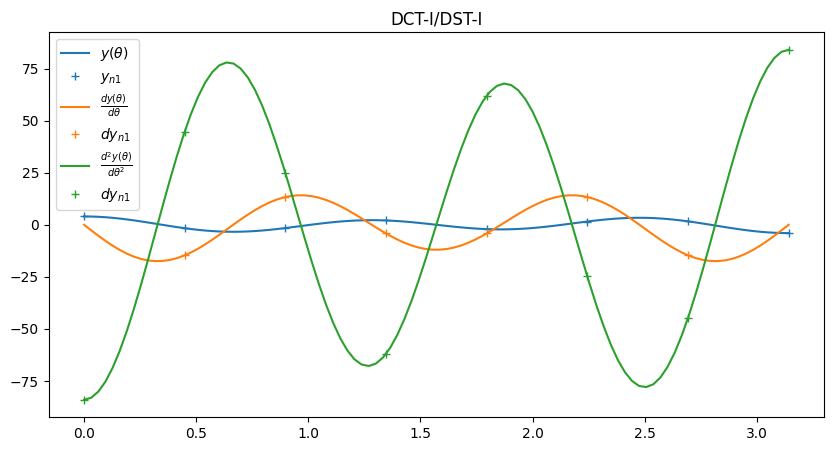

In [4]:
M = 2*N
k = np.arange(N+1); k[-1] = 0 # We zero out the Nyquist term, M/2 = N, corresponding to Y_N

th_n1 = np.linspace(0, np.pi, N+1, endpoint=True) # INCLUDE the endpoint, because [0, ... N]

y_n1 = y(th_n1)
Y_k = dct(y_n1, 1)
Y_p = -k * Y_k # j * (jk) * Y_k
dy_n1 = dst(Y_p[1:-1], 1)/M # The DST-I definition takes only the central (nonzero) part of Y_p
Y_p = -k**2 * Y_k # (jk)**2 * Y_k
d2y_n1 = dct(Y_p, 1)/M # DCT-III

print("L1 dy:", np.max(np.abs(dy_n1 - dy(th_n1)[1:-1]))) # compare against analytic answers
print("L1 d2y:", np.max(np.abs(d2y_n1 - d2y(th_n1))))

pyplot.figure(figsize=(10,5))
pyplot.plot(th, y(th), label=r"$y(\theta)$")
pyplot.plot(th_n1, y_n1, 'C0+', label=r"$y_{n1}$")
pyplot.plot(th, dy(th), label=r"$\frac{dy(\theta)}{d\theta}$")
pyplot.plot(th_n1[1:-1], dy_n1, 'C1+', label=r"$dy_{n1}$")
pyplot.plot(th, d2y(th), label=r"$\frac{d^2y(\theta)}{d\theta^2}$")
pyplot.plot(th_n1, d2y_n1, 'C2+', label=r"$dy_{n1}$")
pyplot.title("DCT-I/DST-I")
pyplot.legend();

The numerically-found derivative matches the analytic truth *perfectly*, and the answes still fall on the $\theta_{n1}$ samples, but the endpoints are missing. This turns out to not be such a problem, though, because we have to find domain endpoints by [L'Hôpital's rule anyway](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev_domain_endpoints.ipynb).

## Derivatives with DCT-II,III and DST-III via Resampling

If we transform to frequency domain with type II, then implicitly we're assuming the data is coming [from half-index points](https://github.com/pavelkomarov/spectral-derivatives/issues/13), $\theta_{n2} = \frac{\pi}{N+1} (n + \frac{1}{2})$, and being transformed to whole number index points. The natural inverses are type III, which assume we're going from whole number index points back the original half-index sample points.

$$
\begin{align*}
Y_k &= \underbrace{2 \sum_{n=0}^N y_n \cos\Big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\Big)}_{\text{DCT-II}}\\
y_n & = \frac{1}{M} \Big( \underbrace{Y_0 + 2 \sum_{k=1}^N Y_k \cos\Big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\Big)}_{\text{DCT-III}} \Big)
\end{align*}
$$

If we substitute $\theta_{n2}$ and then consider continuous $\theta$ and take the derivative of $y(\theta)$, similar to the [derivation of the type I case](https://pavelkomarov.com/spectral-derivatives/math.pdf), and then we resample to match the DCT-III and DST-III, then we get:

$$
\begin{align*}
y_n^{(\text{odd } \nu)} &= \frac{1}{M} \Big( \underbrace{\underbrace{(-1)^n}_{\sin\!\big(\frac{\pi (N + 1)}{N+1} (n + \frac{1}{2})\big)} \cdot \underbrace{0}_{Y_{N+1}'} + 2 \sum_{k=1}^{N} Y_k' \sin\!\big(\frac{\pi k}{N+1}(n + \frac{1}{2})\big)}_{\text{DST-III}} \Big)\\
y_n^{(\text{even } \nu)} &= \frac{1}{M} \Big( \underbrace{\underbrace{0}_{Y_0'} + 2 \sum_{k=1}^N Y_k' \cos\Big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\Big)}_{\text{DCT-III}} \Big)
\end{align*}
$$

For the DST case, [this stackoverflow post](https://stackoverflow.com/questions/57675927/how-to-calculate-spectral-derivative-using-scipy-fftpack-dst-dct) was really helpful.

### Visualizing the Different $\theta_n$ Samplings

It's helpful to look at $\theta_{n1}$ and $\theta_{n2}$ visually.

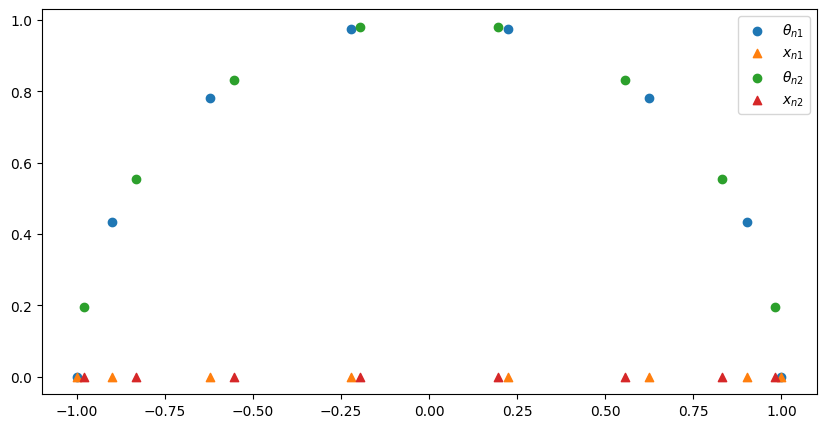

In [5]:
th_n2 = np.pi/(N+1) * (np.arange(N+1) + 0.5) # Sample from half-indices. At n = 0 we're already at 1/2 a step.

pyplot.figure(figsize=(10,5))
pyplot.scatter(np.cos(th_n1), np.sin(th_n1), label=r"$\theta_{n1}$")
pyplot.scatter(np.cos(th_n1), [0 for i in range(len(th_n1))], label=r"$x_{n1}$", marker='^')
pyplot.scatter(np.cos(th_n2), np.sin(th_n2), label=r"$\theta_{n2}$")
pyplot.scatter(np.cos(th_n2), [0 for i in range(len(th_n2))], label=r"$x_{n2}$", marker='^')
pyplot.legend();

The DCT-I/DST-I uses the 1 sampling; the DCT-II,III/DST-III uses the 2 sampling.

## DCT-II/DST-III/DCT-III with $\theta_{n2}$

First let's just see we actually can easily take derivatives with the resampling.

L1 dy: 1.9539925233402755e-14
L1 d2y: 5.5067062021407764e-14


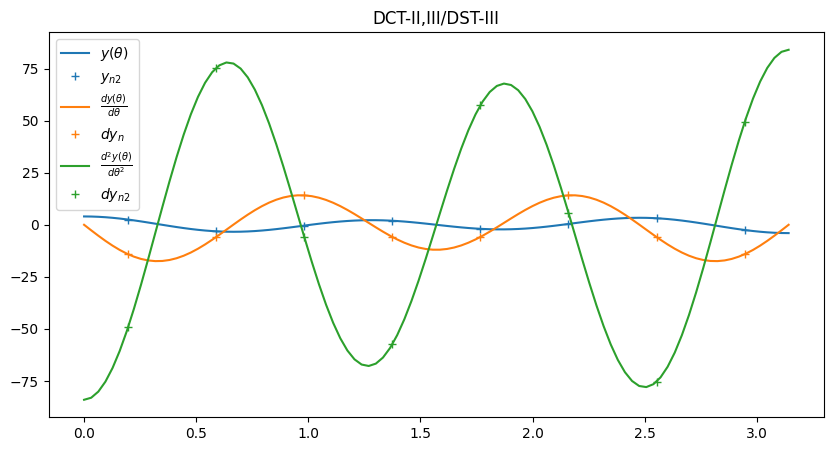

In [6]:
M = 2*(N+1)

y_n2 = y(th_n2) # Sample at half-index points
Y_k = dct(y_n2, 2)
Y_p = -k * Y_k # j * (jk) * Y_k
Y_p = np.roll(Y_p, -1) # shift to left
dy_n2 = dst(Y_p, 3)/M
Y_p = -k**2 * Y_k # (jk)**2 * Y_k
d2y_n2 = dct(Y_p, 3)/M # DCT-III

print("L1 dy:", np.max(np.abs(dy_n2 - dy(th_n2))))
print("L1 d2y:", np.max(np.abs(d2y_n2 - d2y(th_n2))))

pyplot.figure(figsize=(10,5))
pyplot.plot(th, y(th), label=r"$y(\theta)$")
pyplot.plot(th_n2, y_n2, 'C0+', label=r"$y_{n2}$")
pyplot.plot(th, dy(th), label=r"$\frac{dy(\theta)}{d\theta}$")
pyplot.plot(th_n2, dy_n2, 'C1+', label=r"$dy_{n}$")
pyplot.plot(th, d2y(th), label=r"$\frac{d^2y(\theta)}{d\theta^2}$")
pyplot.plot(th_n2, d2y_n2, 'C2+', label=r"$dy_{n2}$")
pyplot.title("DCT-II,III/DST-III")
pyplot.legend();

Notice this example's samplings *don't include the boundary*, because $\theta_{n2}$ doesn't go all the way to the edges of the domain $[0, \pi]$. This may be a problem if we want to impose boundary conditions!

## Mixing Samplings

A natural thing to try if we want to get the domain edges back is to use $\theta_{n1}$ with the II/III transforms. But this doesn't work. Let's see why:

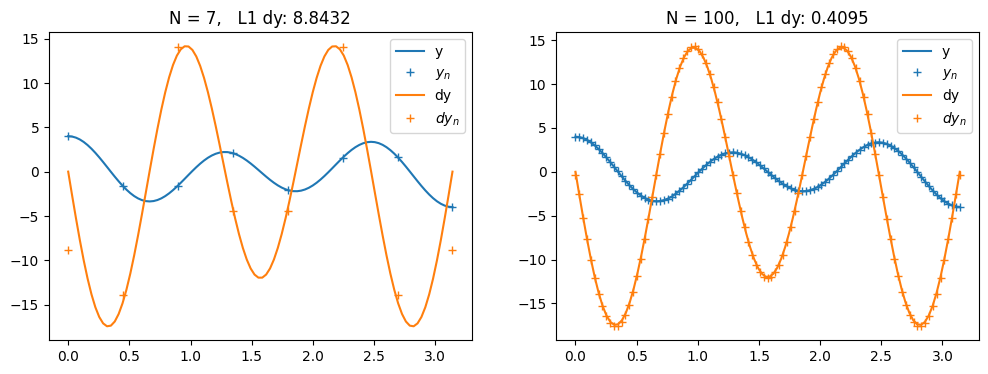

In [7]:
fig, axes = pyplot.subplots(1, 2, figsize=(12,4))

for i,N_ in enumerate([7, 100]):
    M_ = 2*(N_+1)
    th_n_ = np.linspace(0, np.pi, N_+1, endpoint=True) # like th_n1
    k_ = np.arange(N_+1)
    
    y_n_ = y(th_n_)
    Y_k = dct(y_n_, 2) # DCT-II with th_n1 sampling
    Y_p = -k_ * Y_k # j * (jk) * Y_k
    Y_p = np.roll(Y_p, -1) # shift to left
    dy_n_ = dst(Y_p, 3)/M_

    axes[i].plot(th, y(th), label="y")
    axes[i].plot(th_n_, y_n_, 'C0+', label=r"$y_n$")
    axes[i].plot(th, dy(th), label="dy")
    axes[i].plot(th_n_, dy_n_, 'C1+', label="$dy_n$")
    axes[i].legend()
    axes[i].set_title(f"N = {N_},   L1 dy: {np.max(np.abs(dy_n_ - dy(th_n_))):.4f}")

If we sample the function at $\theta_{n1}$, which covers $[0, \pi]$, but then use the II/III transforms, the transforms still assume the data is coming from points $\theta_{n2}$, which covers the interval $[\frac{\pi}{2(N+1)}, \frac{\pi (2N+1)}{2(N+1)}]$. This *compresses* the function slightly, by a factor of $\frac{N}{N+1}$. Frequencies in the compressed version have become *higher* than they should be, so then multiplying by $jk$ isn't quite right! Notice $\frac{N}{N+1} \rightarrow 1$ as $N \rightarrow \infty$, which explains why higher $N$ results in lower error.

We have to correct for this if we want to sample the function at $\theta_{n1}$ yet use the DCT-II,III/DST-III.

## DCT-II/DST-III/DCT-III with $\theta_{n1}$

Can we make some modification to the above to get the samplings to fall on the original 1 sampling? [Phase ramping](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dft_dct_dst_relationship.ipynb) may be relevant.

In [8]:
# M = 2*(N+1)

# y_n2 = y(th_n2) # Sample at half-index points
# Y_k = dct(y_n2, 2)
# Y_p = -k * Y_k # j * (jk) * Y_k
# Y_p = np.roll(Y_p, -1) # shift to left
# dy_n2 = dst(Y_p, 3)/M
# Y_p = -k**2 * Y_k # (jk)**2 * Y_k
# d2y_n2 = dct(Y_p, 3)/M # DCT-III

# print("L1 dy:", np.max(np.abs(dy_n2 - dy(th_n2))))
# print("L1 d2y:", np.max(np.abs(d2y_n2 - d2y(th_n2))))

# pyplot.figure(figsize=(10,5))
# pyplot.plot(th, y(th), label=r"$y(\theta)$")
# pyplot.plot(th_n2, y_n2, 'C0+', label=r"$y_{n2}$")
# pyplot.plot(th, dy(th), label=r"$\frac{dy(\theta)}{d\theta}$")
# pyplot.plot(th_n2, dy_n2, 'C1+', label=r"$dy_{n}$")
# pyplot.plot(th, d2y(th), label=r"$\frac{d^2y(\theta)}{d\theta^2}$")
# pyplot.plot(th_n2, d2y_n2, 'C2+', label=r"$dy_{n2}$")
# pyplot.title("DCT-II,III/DST-III")
# pyplot.legend()